# objective 
20230816
sarahfong

learn the features of the US MPRA dataset

do some basic transformations and comparisons 

## transformations
- per replicate 
    
    - log2 normalize activity values
    - explore standard scaling log2 values (rep ctrl 2 has wider variance than other replicates) 

- across replicates
    - compute median, mean, sd of log2 values, standard scaling values 

## questions
- what is the variance between replicates? 
- How well do replicates correlate with one another?
    - pearson between replicates? 
    - spearman between replicates? 
- what is the correlation across replicate means, medians within group?

- is there are difference between log2 ratio and standard scaling activity? 
- How do we determine sequences that are statistically significantly different between US and controls?
    - Vioation of independent - multiple tiles over the same sequence
    - boneferroni, FDR corrections are nto sufficient. 
    - bootstrap 95% confidence intervals from the shuffled dataset? 
- what is activity correlation between two datasets? 

In [1]:
import config_readwrite as crw

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os, sys

import pandas as pd

import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, StandardScaler

from plot_params import fonts

# Read, write to config

In [2]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

# path
DATA_PATH = config["local_path"]["data"]
RE = config["local_path"]["results"]

# make dictionary of values to write to config
config_dict = {
    "HEPG2": os.path.join(DATA_PATH, "full_hepg2_ultrasound_MPRA.csv"),
    "HEPG2.clean": os.path.join(DATA_PATH, "full_hepg2_ultrasound_MPRA.clean.csv"),
    "HEPG2.clean.transformed": os.path.join(DATA_PATH, "full_hepg2_ultrasound_MPRA.clean.transformed.csv"),
    "HEPG2.clean.trans.scaled": os.path.join(DATA_PATH, "full_hepg2_ultrasound_MPRA.clean.transformed.standard.scaled.csv"),
    "BJ": os.path.join(DATA_PATH, "full_bj_ultrasound_MPRA.csv"),
    "BJ.clean": os.path.join(DATA_PATH, "full_bj_ultrasound_MPRA.clean.csv"),
    "BJ.clean.transformed": os.path.join(DATA_PATH, "full_bj_ultrasound_MPRA.clean.transformed.csv"),
    "BJ.clean.trans.scaled": os.path.join(DATA_PATH, "full_bj_ultrasound_MPRA.clean.transformed.standard.scaled.csv"),
    "FASTA":os.path.join(DATA_PATH, "ultrasound_final_no_adapter.fasta")
}

# make data section of config
section = "data"
crw.check(config, section)

# add dictionary to config
for key, value in config_dict.items():
    config[section][key] = value
    
# write to config    
crw.write(config, cfn)

# functions

## mean, median, std

In [3]:
def computeStats(df, l2_ratios_list):
    """ compute median, mean, std of ctrl and ultrasound replicates per sequence"""
    
    df["l2.ratio.med.ctrl"] = df[l2_ratios_list[:3]].median(axis=1)
    df["l2.ratio.mean.ctrl"] = df[l2_ratios_list[:3]].mean(axis=1)
    df["l2.ratio.std.ctrl"] = df[l2_ratios_list[:3]].std(axis=1)

    df["l2.ratio.med.us"] = df[l2_ratios_list[3:]].median(axis=1)
    df["l2.ratio.mean.us"] = df[l2_ratios_list[3:]].mean(axis=1)
    df["l2.ratio.std.us"] = df[l2_ratios_list[3:]].std(axis=1)
    
    return df

## l2 transform (RNA/DNA) 

In [4]:
def log2Transform(df, ratios_list):
    """ log2 transform each ratio column"""
    
    for ratio in ratios_list:
        df[f"l2.{ratio}"] = np.log2(df[ratio])
    
    return df

## get coordinates

In [5]:
def getCoordinates(df):
    """str split name to get genomic coordinates for endogenous sequences"""
    
    coordf = df.loc[df['name'].str.contains("chr")].copy()

    coordf["coor"] = coordf["name"].apply(
        lambda x: "chr"+x.split("chr")[1] if "chr" in x else None)

    # merge- add coordinates back to dataframe
    return pd.merge(df, coordf, how="left")

 ## compute fold change of medians 

In [6]:
def computeDelta(df):
    """ compute delta of log2 median us - log2 median control"""
    
    df["delta.med"] = df["l2.ratio.med.us"]-df["l2.ratio.med.ctrl"]
    df["delta.mean"] = df["l2.ratio.mean.us"]-df["l2.ratio.mean.ctrl"]
    
    return df

In [7]:
def clOrigin(df, constants_list):
    """annotate which cl a sequence was designed from"""
    
    df["cl.origin"] = None

    for cl in constants_list:
        df.loc[df['name'].str.contains(cl), "cl.origin"] = cl
    
    return df

In [8]:
def ctrlAnnot(df, constants_list):
    """ annotate control type (pos, neg, test)"""
    
    df["type"] = "None"
    for ctrl in constants_list:
        df.loc[df['label'].str.contains(ctrl), "type"] = ctrl
    
    return df

In [9]:
def computePval(df, constants_list):
    """ compute per sequence ttest of ctrl v. ultrasound rep
        assume equal_var is False 
    """
    df["pval"] = None
    for i, row in df.iterrows():

        # get control replicates
        ctrls = row[constants_list[:3]]

         # get US replicates
        uss = row[constants_list[3:]]
        
        # t-test per sequence, no equal variance assumed. 
        t,p = stats.ttest_ind(list(ctrls), list(uss), equal_var=False)
        
        # update dataframe
        df.at[i,'pval'] = p
        
    return df

## bootstrap

In [10]:
def bootstrap(data_list, size, stat):  
    
    """
    return the discrete and relative 95% confidence intervals of a data_list 
    
    input
        list of data (list, continuous values) - any list of data values, must be continuous values. 
        size (int) - size of dataset to bootstrap from list. If None, make bootstrapped distribution from entire list
        stat (float or "mean") - quantile to bootstrap (float, 0-1) or mean (str)
        
    method 
        1. If size is None, get the length of the list 
        2. get the observed stat of the list (mean, median, quantile)
        3. set bootstrap parameters
        4. per iteration, randomly choose elements from the fold changes list w replacement
        5. append the stat to the list of bootstrapped_stat
        6. turn stats into a dataframe
        7. calculate the delta distances from the population stat. This centers the data.
        8. sort from largest to smallest difference
        9. get discrete 0.025 adn 0.975 quantile values of the centered stat distribution. 
        10. calculate relative confidence intervals and actual confidence interval values (population stat - quantile values)
    """
    
    #1
    if size is None:    
        size = len(data_list) # size of distribution to bootstrap

    #2
    if type(stat) is float:
        obs_stat = np.quantile(data_list, stat) # get observed stat
        
    elif stat=="mean":
        obs_stat = np.mean(data_list) # get observed stat
    
    #3
    nboot = 10000 # resample 10000 times
    val = 0
    bs_stats = []
    
    #4
    while val < nboot:

        bs_dist = np.random.choice(data_list, replace = True, size = size)
        
        #5
        if type(stat) is float:
            bs_stat = np.quantile(bs_dist, stat)
        elif stat=="mean":
            bs_stat = np.mean(bs_dist)
            
        bs_stats.append(bs_stat)
        val +=1
    #6
    bs = pd.DataFrame(data = bs_stats, 
                      index = np.arange(nboot), 
                      columns = ["bs_stat"]) # make dataframe of bootstraps

    #7 center the stat distribution
    bs["deltas"] = bs["bs_stat"] - obs_stat

    #8
    bs = bs.sort_values(by = "deltas", ascending= False)
    
    #9  get discrete 95th CI
    low = bs.deltas.quantile(0.025) 
    high = bs.deltas.quantile(0.975)
    ci_relative = [high, low]  # assume obs value is centered at zero

    #10  return ci relative to observed stat 
    ci_discrete = obs_stat - [high, low]  # assume obs value is center
   
    print(f"measure CI of {stat} quantile| mean estimate\n observed {stat} value:", 
          obs_stat,  
          "\ndiscrete diff from observed:", ci_discrete, 
          "\nrelative diff from observed:", ci_relative)
    return ci_discrete, ci_relative

In [11]:
def callActive(df):
    """call active elements from ctrl, us MPRA as values > 95 of shuffled regions"""
    
    # get shuffles
    shufs = df.loc[df.name.str.contains("shuf")].copy()
    
    # get 97.5% of shuffle median score for ctrl, US treatment
    ctrl_975 = shufs['l2.ratio.med.ctrl'].quantile(0.975)
    us_975 = shufs['l2.ratio.med.us'].quantile(0.975)
    
    
    ctrl_025 = shufs['l2.ratio.med.ctrl'].quantile(0.025)
    us_025 = shufs['l2.ratio.med.us'].quantile(0.025)
    print(ctrl_975,ctrl_025, us_975, us_025)

    # create column to label active
    df['label.ctrl'], df['label.us']=False, False
    
    # label active elements - has more activity than 97.5% shuffles
    df.loc[df['l2.ratio.med.ctrl']>ctrl_975, 'label.ctrl']=True
    df.loc[df['l2.ratio.med.us']>us_975, 'label.us']=True

    # label active elements - has less activity than 2.5% shuffles
    df.loc[df['l2.ratio.med.ctrl']<ctrl_025, 'label.ctrl']=True
    df.loc[df['l2.ratio.med.us']<us_025, 'label.us']=True
    
    return df

In [12]:
def callResponse(df):
    df["response"] = False
    
    df.loc[(df["pval"]<0.005)&
          (df['label.ctrl']!=df['label.us']),
           "response"
          ] = True
    
    return df

# test cell line 

## notes about this dataset
- Activity score - median score was assigned per US|CTRL for each sequence
- Active | inactive = test sequence score > 95% shuffled score. Both these scores are median score (above)
- logFC
- P-value

### constants dict

In [13]:
constants = {
    "NAMES" :['name',
         'label',
         'ratio.med.ctrl',
         'label.ctrl',
         'ratio.1.ctrl',
         'ratio.2.ctrl',
         'ratio.3.ctrl',
         'ratio.med.us',
         'label.us',
         'ratio.1.us',
         'ratio.2.us',
         'ratio.3.us',
         'pval',
         'logFC',
         'response'],
    
    "CTRL_LIST" : ["neg", "pos", "shuffle", "synthetic", 'k27ac', "atac", "DEG"],
    
    "RATIOS": ['ratio.1.ctrl','ratio.2.ctrl', 'ratio.3.ctrl', 
          'ratio.1.us', 'ratio.2.us','ratio.3.us'],
    
    "L2RATIOS": ['l2.ratio.1.ctrl','l2.ratio.2.ctrl', 'l2.ratio.3.ctrl', 
          'l2.ratio.1.us', 'l2.ratio.2.us','l2.ratio.3.us'],
    
    "CL_LIST" :["k562", "hob", "bj", "hepg2"]
}

### input data

In [14]:
CLS = ["HEPG2", "BJ"]
cls ={}
for CL in CLS:
    DATA = config_dict[CL]
    CLEAN = config_dict[f"{CL}.clean.transformed"]

    ### load data

    if os.path.exists(CLEAN) is False:
        # load .csv data, rename columns, skip row 1 (old column names)
        df_ = pd.read_csv(DATA, skiprows=1, names=constants["NAMES"], low_memory=False)

        # annotate cell line origin
        df = clOrigin(df_, constants["CL_LIST"])

        # annotate controls
        df = ctrlAnnot(df,constants["CTRL_LIST"])

        # coordinates
        df = getCoordinates(df)

        # log2 transform ratios - increase sensitivity for ratios <1
        df = log2Transform(df, constants["RATIOS"])

        # compute stats
        df = computeStats(df, constants["L2RATIOS"])

        # compute difference between scaled
        df = computeDelta(df)

        # recall active
        df = callActive(df)

        # re compute pvalues 
        df = computePval(df, constants["L2RATIOS"])

        # recall response
        df = callResponse(df)
        # write the file

        df.to_csv(CLEAN, sep='\t', index=False)
        print('wrote clean')

    else:
        df = pd.read_csv(CLEAN, sep='\t')
    df["CL"] = CL
    cls[CL] = df
    df.head()

In [15]:
df = pd.concat(cls.values())

In [16]:
df.head()

,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,ratio.1.us,...,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,CL
0,SYNTHETIC:_Added_CCTTCCTG_GCCCGGGGG_TATACATA_a...,synthetic,0.488151,False,0.480700,0.488151,0.491067,0.569507,False,0.559691,...,-0.808342,-1.034599,-1.039134,0.015885,-0.812215,-0.819284,0.015719,0.222385,0.219849,HEPG2
1,hob_k27ac_up_chr1:67427680-67427949,k27ac,0.758301,False,0.758301,0.763843,0.753815,0.686366,False,0.686366,...,-0.524077,-0.399158,-0.398509,0.009549,-0.542950,-0.538709,0.013039,-0.143792,-0.140200,HEPG2
2,SYNTHETIC:_The_motif_ATTAAA_was_added_in_Pos:8...,synthetic,0.712807,False,0.729310,0.712807,0.711749,0.864872,False,0.864872,...,-0.188154,-0.488417,-0.478124,0.019712,-0.209442,-0.210023,0.022166,0.278975,0.268100,HEPG2
3,SYNTHETIC:_Added_TATGACTCATA_ACAGGTGTAC_ACAGGT...,synthetic,0.860961,False,0.889910,0.848101,0.860961,0.624727,False,0.624727,...,-0.600124,-0.215980,-0.207313,0.035514,-0.678703,-0.652872,0.045684,-0.462723,-0.445559,HEPG2
4,k562_atac_up_chr15:78056378-78056647,atac,1.662392,True,1.640097,1.662392,1.674355,1.441707,True,1.450990,...,0.527778,0.733260,0.730216,0.015143,0.527778,0.520052,0.021896,-0.205483,-0.210164,HEPG2


## QC old df v. new df

In [17]:
def harmonizeOldDf(df_):
    df_.loc[df_["label.ctrl"] == "inactive", "label.ctrl"] = False
    df_.loc[df_["label.ctrl"] == "active", "label.ctrl"] = True
    df_.loc[df_["label.us"] == "inactive", "label.us"] = False
    df_.loc[df_["label.us"] == "active", "label.us"] = True
    
    df_.loc[df_["response"] =="ultrasound-responsive", "response" ] = True
    df_.loc[df_["response"] =="unresponsive", "response" ] = False
    
    return df_

In [18]:
def checkCoor(old_df, new_df, col):
    """
    check correlations before and after log transforming data
    """
    old_col = 'old-'+col
    
    old = old_df[["name", col]].drop_duplicates()
    new = new_df[["name", col]].drop_duplicates()
    
    old = old.rename(columns={col:'old-'+col})

    print(list(old), list(new))
    
    m = pd.merge(old[["name", 'old-'+col]], 
                 new 
                )
    print(m[[old_col, col]].corr())

### harmonize old df with bool

In [19]:
# load .csv data, rename columns, skip row 1 (old column names)
df_ = pd.read_csv(DATA, skiprows=1, names=constants["NAMES"], low_memory=False)

df_ = harmonizeOldDf(df_)

not sure if response column rules are correct. Correct according to methods. 

## Within group replicate correlation? 

### plot function

In [20]:
def plotCorrHeatMap(data,cols):
    """ plot pearson and spearman correlation between columns in a dataframe"""
    pearson = data[cols].corr()
    spearman = data[cols].corr(method="spearman")
    
    matrix_p = np.triu(pearson)
    matrix_s = np.triu(spearman)
    
    # pearson
    fig,ax=plt.subplots()
    sns.heatmap(pearson, 
                annot=True, 
                mask=matrix_p,
                center=0,
                cbar_kws={"label":"pearson"}) 

    # spearman
    fig,ax=plt.subplots()
    sns.heatmap(spearman, 
                annot=True,
                mask=matrix_s,
                center=0,
                cbar_kws={"label":"spearman"})

### within replicates, Pearson, Spearman

In [21]:
constants.keys()

dict_keys(['NAMES', 'CTRL_LIST', 'RATIOS', 'L2RATIOS', 'CL_LIST'])

In [22]:
ratios=constants["L2RATIOS"]

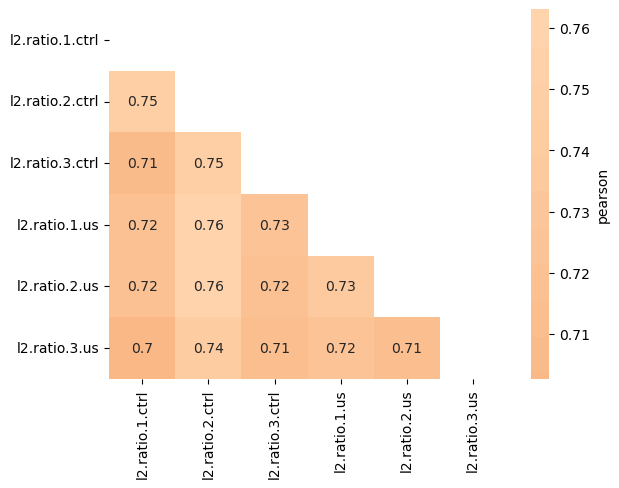

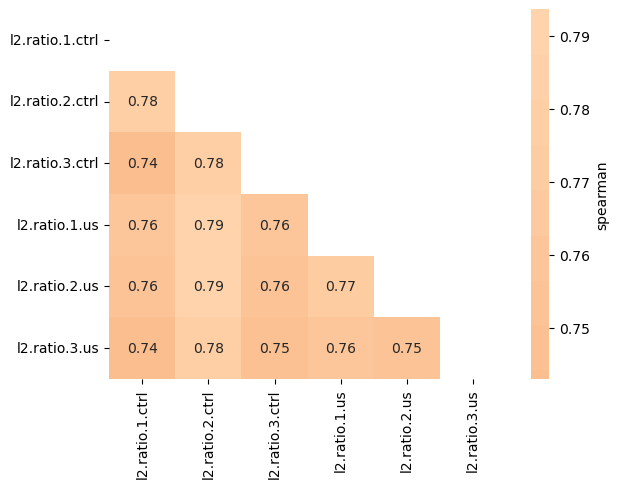

In [23]:
data = df
cols = ratios

plotCorrHeatMap(data,cols)

In [24]:
df.shape

(135841, 33)

In [25]:
set(df["CL"])

{'BJ', 'HEPG2'}

### problem = control 2 has greater variance. 

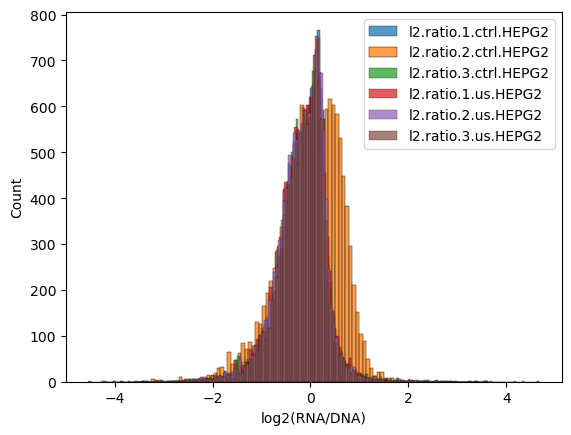

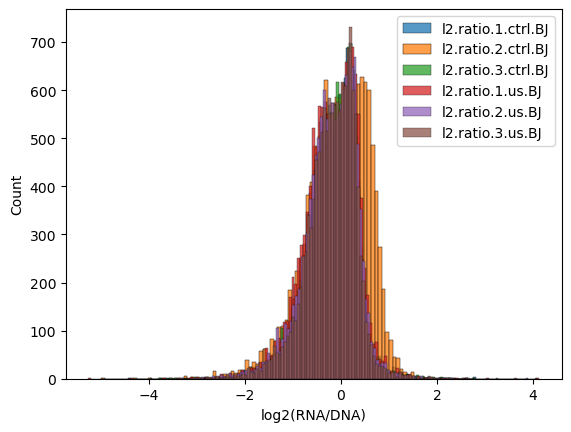

In [26]:
for cl in set(df["CL"]):
    fig,ax=plt.subplots()
    data=df.loc[df["CL"]==cl]
    for col in ratios:
        sns.histplot(data[col].sample(frac=0.2), label=(col +"."+ cl))
    plt.legend()
    ax.set(xlabel = 'log2(RNA/DNA)')

# Standard scaling per replicate

In [27]:
SCALED = '/wynton/home/ahituv/fongsl/EMF/US/data/full_bjandhepg2_ultrasound_MPRA.clean.transformed.standard.scaled.csv'

In [28]:
scaled = {}
for CL in CLS:
    SCALED =config_dict[f'{CL}.clean.trans.scaled']

    if os.path.exists(SCALED) is False:
        X = df[ratios]

        transformer = StandardScaler()

        t = pd.DataFrame(transformer.fit_transform(X[ratios]))

        t.columns = ratios # rename columns 

        ### mean, median of standardized values

        t = computeStats(t, ratios)

        # compute delta
        t = computeDelta(t)

        ### compute p value on standardized scale
        t = computePval(t, ratios)

        # add back names
        t = pd.merge(df['name'], t, left_index=True,right_index=True)

        # recall active
        t = callActive(t)

        # recall response
        t = callResponse(t)

        # write
        t.to_csv(SCALED, sep='\t', index=False)


    else:
        t= pd.read_csv(SCALED, sep='\t')
        t["CL"] = CL
        scaled[CL]=t
    t.head()

In [29]:
t = pd.concat(scaled.values())

HEPG2
BJ


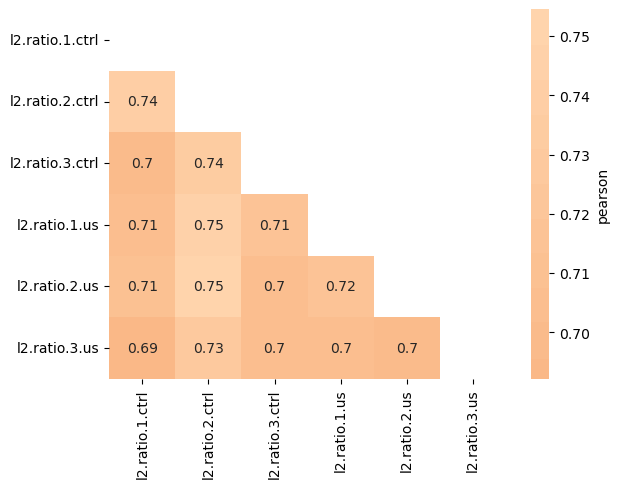

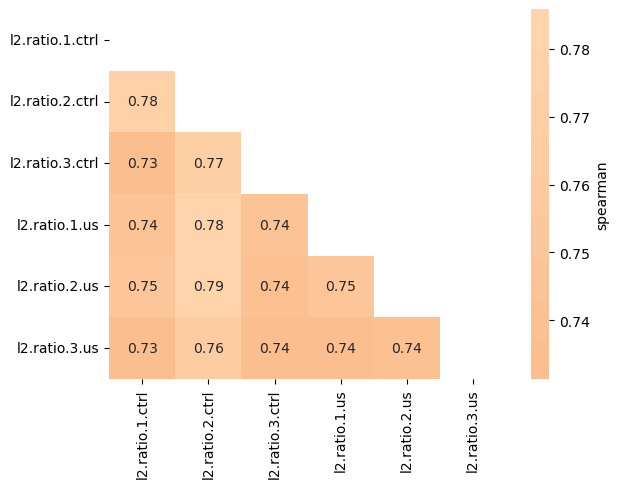

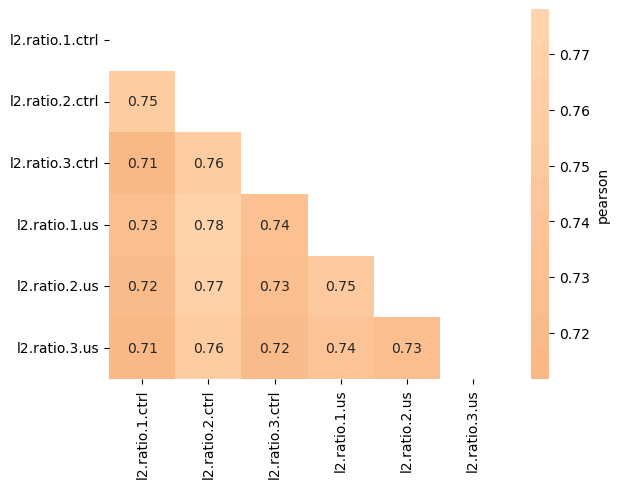

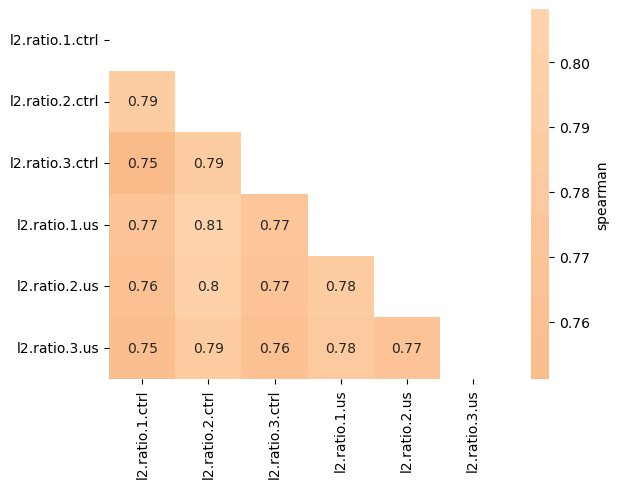

In [30]:
for cl in CLS:
    print(cl)
    data = t.loc[t["CL"]==cl]
    cols = ratios

    plotCorrHeatMap(data,cols)

##### After transform, the correlations between the sets are still the same
##### but the values are scaled to account for variance between replicates

HEPG2
BJ


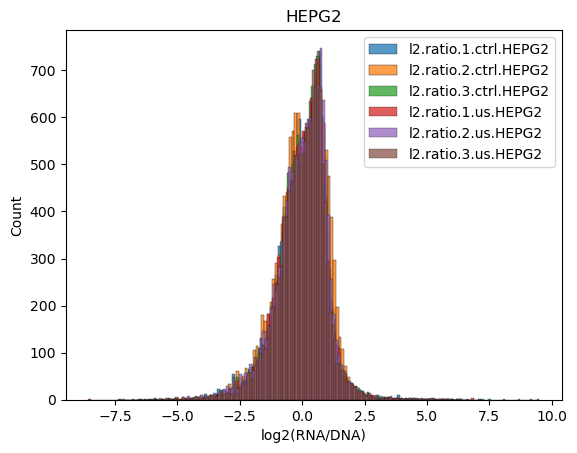

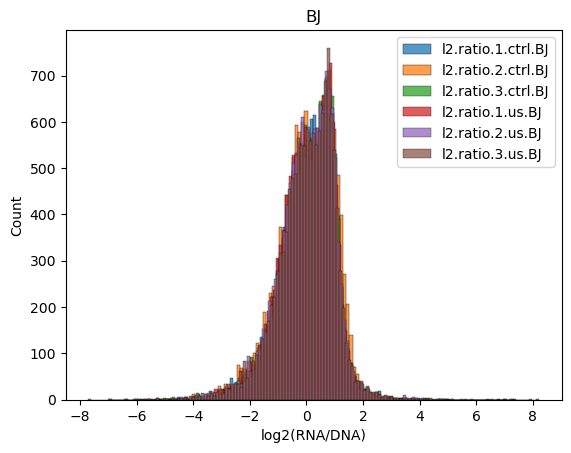

In [31]:
for cl in CLS:
    print(cl)
    data = t.loc[t["CL"]==cl]
    fig,ax=plt.subplots()
    for col in ratios:
        sns.histplot(data[col].sample(frac=0.2), label=col +"."+cl)
    plt.legend()
    ax.set(xlabel = 'log2(RNA/DNA)', 
          title=cl)

In [32]:
t = pd.merge(t, df[["name", "type"]])

In [33]:
tiny = t[["delta.mean", "CL", "name", "type"]].drop_duplicates()
table = tiny.pivot(index=["name", "type"], columns = "CL", values="delta.mean")
table.head()

,CL,BJ,HEPG2
name,type,,
BJ_down-DEG-prom_ENSG00000258064_chr12:71672690-71672959:+,DEG,-0.048854,-0.007771
BJ_down-DEG-prom_ENSG00000258064_chr12:71672935-71673204:+,DEG,-0.109182,-0.044514
BJ_down-DEG-prom_ENSG00000258064_chr12:71673180-71673449:+,DEG,0.068272,0.068092
BJ_down-DEG-prom_ENSG00000258064_chr12:71673425-71673694:+,DEG,-0.042303,-0.088433
BJ_down-DEG-prom_ENSG00000258064_chr12:71673670-71673939:+,DEG,0.068457,-0.145091


In [34]:
table.corr()

CL,BJ,HEPG2
CL,,
BJ,1.000000,0.060726
HEPG2,0.060726,1.000000


In [35]:
table.corr(method="kendall")

CL,BJ,HEPG2
CL,,
BJ,1.000000,0.053715
HEPG2,0.053715,1.000000


In [36]:
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

<Axes: xlabel='delta.mean', ylabel='Density'>

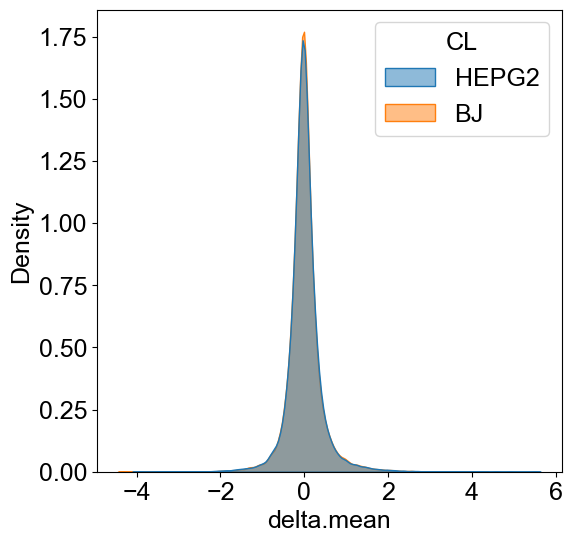

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(x="delta.mean", data=tiny, hue="CL", 
               fill=True, common_norm=False, 

   alpha=.5, linewidth=1,
            )

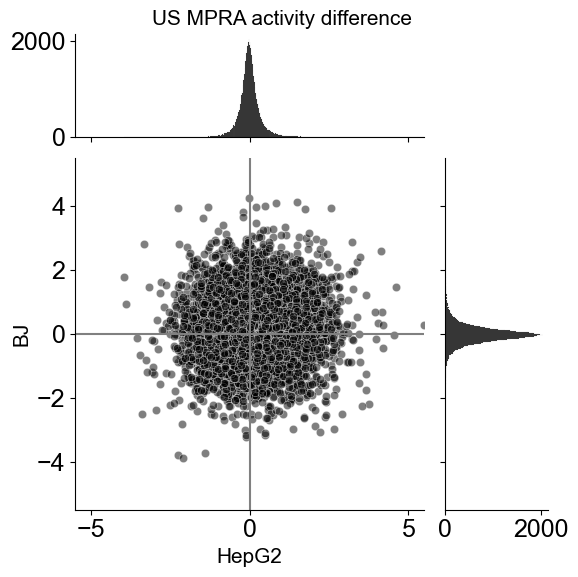

In [38]:
g = sns.jointplot(data=table, x="HEPG2", y="BJ",
                   #kind="hist",
                  #marker="+", s=100,
                  alpha=0.5,
                  height=6, ratio=3, marginal_ticks=True,
                 xlim=(-5.5, 5.5), ylim=(-5.5, 5.5),
                  color="black",

                  )
g.fig.suptitle("US MPRA activity difference",size=15)

plt.axvline(0, color="grey")  # vertical axis
plt.axhline(0, color="grey")  # horizontal axis

# set labels
g.set_axis_labels(xlabel='HepG2', ylabel='BJ', size=15)

out = os.path.join(RE, f"scatter.Hepg2.BJ.delta.mean.pdf")
plt.savefig(out, bbox_inches="tight")

In [39]:
table

,CL,BJ,HEPG2
name,type,,
BJ_down-DEG-prom_ENSG00000258064_chr12:71672690-71672959:+,DEG,-0.048854,-0.007771
BJ_down-DEG-prom_ENSG00000258064_chr12:71672935-71673204:+,DEG,-0.109182,-0.044514
BJ_down-DEG-prom_ENSG00000258064_chr12:71673180-71673449:+,DEG,0.068272,0.068092
BJ_down-DEG-prom_ENSG00000258064_chr12:71673425-71673694:+,DEG,-0.042303,-0.088433
BJ_down-DEG-prom_ENSG00000258064_chr12:71673670-71673939:+,DEG,0.068457,-0.145091
...,...,...,...
k562_k27ac_up_chrX:154123598-154123867,k27ac,-0.998070,1.280750
k562_k27ac_up_chrX:154123730-154123999,k27ac,-1.431420,0.435732
k562_k27ac_up_chrX:154123863-154124132,k27ac,-0.597854,0.225832


# bootstrap 95ci

## full distribution bootstrap

In [40]:
bst_dict = {} 
for CL in CLS:
    print(CL)
    bs_name = "95ci.bootstrap"
    data = t.loc[t["CL"]==CL]
    ci_97_dis, ci97_rel= bootstrap(data["delta.mean"], None, 0.975)
    ci_02_dis, ci902_rel = bootstrap(data["delta.mean"], None, 0.025)

    max97, min02 = max(ci_97_dis), min(ci_02_dis)
    cl = tiny.loc[tiny["CL"]==CL].copy()
    cl["bs_02"], cl["bs_97"] = min02, max97
    
    # bs labels
    cl[bs_name] = "no effect"
    cl.loc[cl["delta.mean"] < min02, bs_name] = "silencing"
    cl.loc[cl["delta.mean"] > max97, bs_name] = "activating"
    bst_dict[CL] = cl
test = pd.concat(bst_dict.values())
test.head()

HEPG2
measure CI of 0.975 quantile| mean estimate
 observed 0.975 value: 0.9622141315887599 
discrete diff from observed: [0.9461773  0.97858704] 
relative diff from observed: [0.01603683652010146, -0.016372906722048653]
measure CI of 0.025 quantile| mean estimate
 observed 0.025 value: -0.7902090282722894 
discrete diff from observed: [-0.80321121 -0.78148918] 
relative diff from observed: [0.013002186675803329, -0.00871984835674633]
BJ
measure CI of 0.975 quantile| mean estimate
 observed 0.975 value: 0.9629842662917952 
discrete diff from observed: [0.94868351 0.97669097] 
relative diff from observed: [0.014300760450758343, -0.01370669918719758]
measure CI of 0.025 quantile| mean estimate
 observed 0.025 value: -0.7722461668451776 
discrete diff from observed: [-0.78248191 -0.76165879] 
relative diff from observed: [0.010235739290442192, -0.010587378916346313]


,delta.mean,CL,name,type,bs_02,bs_97,95ci.bootstrap
0,0.396674,HEPG2,SYNTHETIC:_Added_CCTTCCTG_GCCCGGGGG_TATACATA_a...,synthetic,-0.803211,0.978587,no effect
4,-0.231938,HEPG2,hob_k27ac_up_chr1:67427680-67427949,k27ac,-0.803211,0.978587,no effect
8,0.574042,HEPG2,SYNTHETIC:_The_motif_ATTAAA_was_added_in_Pos:8...,synthetic,-0.803211,0.978587,no effect
12,-0.823169,HEPG2,SYNTHETIC:_Added_TATGACTCATA_ACAGGTGTAC_ACAGGT...,synthetic,-0.803211,0.978587,silencing
16,-0.208711,HEPG2,k562_atac_up_chr15:78056378-78056647,atac,-0.803211,0.978587,no effect


In [41]:
test.groupby(["CL", "95ci.bootstrap"])["name"].count()

CL     95ci.bootstrap
BJ     activating         1658
       no effect         64532
       silencing          1657
HEPG2  activating         1679
       no effect         64660
       silencing          1655
Name: name, dtype: int64

HEPG2


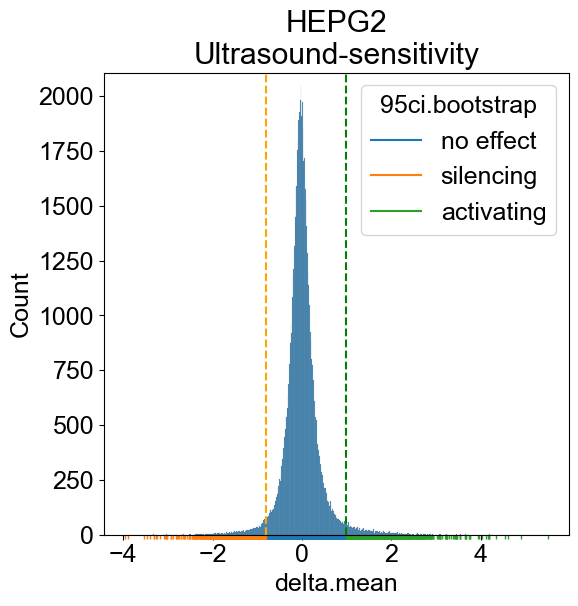

In [42]:
bst_dict = {} 
for CL in CLS:
    print(CL)
    bs_name = "95ci.bootstrap"
    fig, ax=plt.subplots(figsize=(6,6))
    data = test.loc[test["CL"]==CL]
    sns.histplot(x="delta.mean", data=data, 

               )
    sns.rugplot(x="delta.mean", data=data,  hue=bs_name, 
                height=-.01, 
                clip_on=False, 
                lw=1, 
                #alpha=.5,

               )
    ax.axvline(test['bs_97'].iloc[0], ls="--", c="green")
    ax.axvline(test['bs_02'].iloc[0], ls="--", c="orange")
    ax.set(title=CL + "\nUltrasound-sensitivity")
    
    break

## bootstrap shuffled distribution

In [43]:
bst_dict_shuf = {} 
for CL in CLS:
    print(CL)
    bs_name = "95ci.shuf.bootstrap"
    data = t.loc[(t["CL"]==CL) & (t["name"].str.contains("shuffle"))].copy()
    ci_97_dis, ci97_rel= bootstrap(data["delta.mean"], None, 0.975)
    ci_02_dis, ci902_rel = bootstrap(data["delta.mean"], None, 0.025)

    max97, min02 = max(ci_97_dis), min(ci_02_dis)
    cl = tiny.loc[tiny["CL"]==CL].copy()
    cl["bs_02"], cl["bs_97"] = min02, max97
    
    # bs labels
    cl[bs_name] = "no effect"
    cl.loc[cl["delta.mean"] < min02, bs_name] = "silencing"
    cl.loc[cl["delta.mean"] > max97, bs_name] = "activating"
    bst_dict[CL] = cl

test_shuf = pd.concat(bst_dict.values())
test_shuf.head()

HEPG2
measure CI of 0.975 quantile| mean estimate
 observed 0.975 value: 0.6998732308645919 
discrete diff from observed: [0.54001581 0.75445011] 
relative diff from observed: [0.15985742254882895, -0.054576884094301614]
measure CI of 0.025 quantile| mean estimate
 observed 0.025 value: -0.5479670616233983 
discrete diff from observed: [-0.62569846 -0.42298821] 
relative diff from observed: [0.07773139350665575, -0.1249788496463965]
BJ
measure CI of 0.975 quantile| mean estimate
 observed 0.975 value: 0.6490340864440327 
discrete diff from observed: [0.51677479 0.74434693] 
relative diff from observed: [0.1322592948397764, -0.09531284413399987]
measure CI of 0.025 quantile| mean estimate
 observed 0.025 value: -0.607929260901623 
discrete diff from observed: [-0.68109553 -0.53900759] 
relative diff from observed: [0.07316626475529919, -0.06892167461078869]


,delta.mean,CL,name,type,bs_02,bs_97,95ci.shuf.bootstrap
0,0.396674,HEPG2,SYNTHETIC:_Added_CCTTCCTG_GCCCGGGGG_TATACATA_a...,synthetic,-0.625698,0.75445,no effect
4,-0.231938,HEPG2,hob_k27ac_up_chr1:67427680-67427949,k27ac,-0.625698,0.75445,no effect
8,0.574042,HEPG2,SYNTHETIC:_The_motif_ATTAAA_was_added_in_Pos:8...,synthetic,-0.625698,0.75445,no effect
12,-0.823169,HEPG2,SYNTHETIC:_Added_TATGACTCATA_ACAGGTGTAC_ACAGGT...,synthetic,-0.625698,0.75445,silencing
16,-0.208711,HEPG2,k562_atac_up_chr15:78056378-78056647,atac,-0.625698,0.75445,no effect


HEPG2
BJ


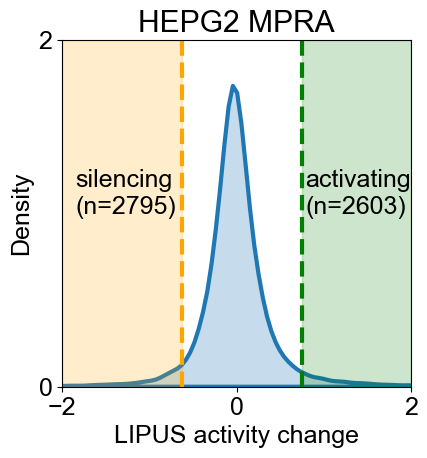

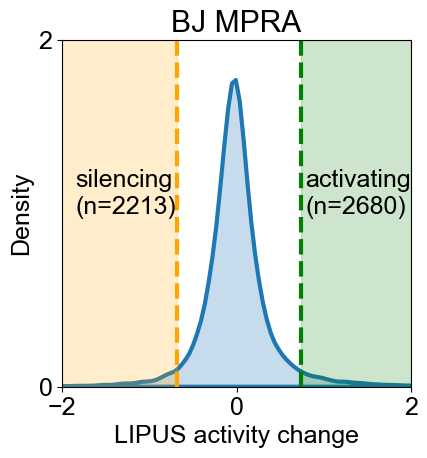

In [44]:
bst_dict = {} 
for CL in CLS:
    print(CL)
    bs_name = "95ci.shuf.bootstrap"
    fig, ax=plt.subplots(figsize=(4.5,4.5))
    data = test_shuf.loc[test_shuf["CL"]==CL]
    sns.kdeplot(x="delta.mean", data=data, 
                #hue='type', 
                #stat="percent",
                lw=3,
                fill =True,
                 common_norm=False, 
               )
    """
    sns.rugplot(x="delta.mean", data=data,  hue=bs_name, 
                height=-.01, 
                clip_on=False, 
                lw=1, 
                #alpha=.5,

               )
   """
    ci_hi, ci_lo = data['bs_97'].iloc[0], data['bs_02'].iloc[0]
    ax.axvline(ci_hi, ls="--", c="green", lw=3)
    ax.axvline(ci_lo, ls="--", c="orange", lw=3)
    
    ax.set(title=CL + " MPRA",
           xlim=(-2,2),
           xlabel ="LIPUS activity change",
           ylim=(0,2)
          )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    
    # compute counts of activated/ silenced
    counts = data.groupby(["CL", "95ci.shuf.bootstrap"])["name"].count().reset_index()
    s_counts = counts.loc[counts[bs_name]=="silencing", "name"].iloc[0]
    a_counts = counts.loc[counts[bs_name]=="activating", "name"].iloc[0]

    # annotat counts
    ax.text(-1.85, 1, f"silencing\n(n={s_counts})") 
    ax.axvspan( ci_lo , -2, alpha=0.2, color="orange")
    ax.text(0.79, 1, f"activating\n(n={a_counts})")
    ax.axvspan( ci_hi , 2, alpha=0.2, color="green")
    
   
    #ax.legend(loc="upper right")
    out = os.path.join(RE, f"bs.{CL}.delta.mean.png")
    plt.savefig(out, bbox_inches="tight")


# examples of LIPUS differences

In [45]:
short = df[['l2.ratio.1.ctrl',
            'l2.ratio.2.ctrl',
            'l2.ratio.3.ctrl',
            'l2.ratio.1.us',
            'l2.ratio.2.us',
            'l2.ratio.3.us',
           'l2.ratio.std.ctrl',   
            'l2.ratio.std.us', 
            'l2.ratio.med.ctrl', 
            'l2.ratio.med.us', 
            'delta.mean', "delta.med", "name", "CL"]].drop_duplicates()

short.loc[(short["l2.ratio.std.ctrl"] < 0.1) &
          (short["l2.ratio.std.us"] < 0.1)&
          short["l2.ratio.med.us"]>0.8
         ].sort_values(by="delta.med", ascending=False).tail(15)

,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.std.ctrl,l2.ratio.std.us,l2.ratio.med.ctrl,l2.ratio.med.us,delta.mean,delta.med,name,CL
137,0.276142,0.221922,0.406265,-0.245382,-0.204687,-0.084984,0.094740,0.083379,0.276142,-0.204687,-0.479794,-0.480828,SYNTHETIC:_Added_CCCCCCCCCCC_TGAGTCATCC_CCTCAT...,BJ
45,0.258249,0.385675,0.301601,-0.111901,-0.196477,-0.193797,0.064788,0.048075,0.301601,-0.193797,-0.482567,-0.495398,SYNTHETIC:_Added_ACAGGTGTAC_CAAGAGTACAGA_ACAGG...,HEPG2
88,0.030892,0.191860,0.140677,-0.358430,-0.356699,-0.221612,0.082243,0.078497,0.140677,-0.356699,-0.433390,-0.497376,SYNTHETIC:_Added_ATTAAA_GGTGACTG_CACCTG_GGGGCG...,HEPG2
220,0.369820,0.505969,0.324685,-0.073979,-0.134822,-0.167359,0.094373,0.047400,0.369820,-0.134822,-0.525544,-0.504642,SYNTHETIC:_Added_GCCCGGGGG_GGGGCGGGG_AGGCCTGG_...,HEPG2
149,0.264066,0.254907,0.256217,-0.251806,-0.122994,-0.252649,0.004953,0.074614,0.256217,-0.251806,-0.467546,-0.508023,hepg2_atac_up_chr17:76851142-76851411,HEPG2
29,-0.073534,-0.156933,-0.156330,-0.760581,-0.671225,-0.565190,0.047977,0.097814,-0.156330,-0.671225,-0.536733,-0.514895,SYNTHETIC:_The_motif_GGTCCCAGCCTT_was_added_in...,BJ
171,0.274109,0.445315,0.429494,-0.138887,-0.088046,-0.000684,0.094610,0.069901,0.429494,-0.088046,-0.458845,-0.517540,SYNTHETIC:_Added_AATATTACAT_TTGTCTGG_CCCCGGCGC...,BJ
64,-0.342489,-0.289384,-0.447884,-0.870015,-0.798336,-0.944569,0.080675,0.073121,-0.342489,-0.870015,-0.511054,-0.527526,SYNTHETIC:_The_motif_CACCTG_was_added_in_Pos:8...,BJ
7,0.378144,0.336044,0.332320,-0.312720,-0.205787,-0.175579,0.025450,0.072059,0.336044,-0.205787,-0.580198,-0.541831,hepg2_atac_up_chr11:57235711-57235980,HEPG2
62,0.788549,0.817171,0.955944,0.218977,0.399692,0.270046,0.089534,0.093161,0.817171,0.270046,-0.557649,-0.547124,SYNTHETIC:_Added_TCACTCA_CAGGAACGGGGCGCACAGGGC...,HEPG2


In [46]:
# pick two illustrative examples. 
up_down = ["hob_k27ac_down_chr2:69307179-69307448", "hepg2_atac_up_chr11:57235711-57235980"]
ud = short.loc[short.name.isin(up_down)]

In [47]:
# get dataframe for those two examples
a = pd.melt(ud, id_vars=["name", "CL"], value_vars =[
    'l2.ratio.1.ctrl',
    'l2.ratio.2.ctrl',
    'l2.ratio.3.ctrl',
    'l2.ratio.1.us',
    'l2.ratio.2.us',
    'l2.ratio.3.us',])
a["exp"] = a["variable"].apply(lambda x: x.split(".")[-1])
a.loc[a["exp"]=="us", "exp"] = "LIPUS"
a["exp2"] = a["CL"] +"-"+ a["exp"]

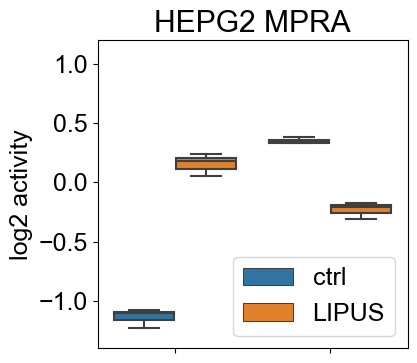

In [49]:
CL = "HEPG2"
fig, ax=plt.subplots(figsize=(4,4))
sns.boxplot(x="name", y="value",
            data=a.loc[a["CL"]==CL], 
            order =up_down,
            hue="exp", #palette = "RdGy_r", 
            hue_order = [ 'ctrl',"LIPUS"], 
           )


ax.set(ylabel="log2 activity", 
      ylim=(-1.4, 1.2),
      xlabel = "", 
      title=CL + " MPRA")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.set_xticklabels(["", ""])#["chr2:69307179-69307448", 'chr11:57235711-57235980'])#, rotation=25, horizontalalignment="right")
ax.legend(loc="lower right")
out = os.path.join(RE, f"bs.{CL}.example.png")
plt.savefig(out, bbox_inches="tight")

In [105]:
short.sort_values(by="delta.med", ascending=False).head(15)

,delta.mean,delta.med,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.med.us,name,CL
12561,1.444507,2.935531,-2.148715,-2.663956,-0.864077,0.786816,-3.413895,1.283852,-2.148715,0.786816,hob_k27ac_down_chrX:1391681-1391950,HEPG2
10479,1.809942,2.827599,0.701906,-1.445503,-1.630261,2.033477,1.382096,-0.359606,-1.445503,1.382096,SYNTHETIC:_The_motif_CCCCCGCCCC_was_added_in_P...,BJ
9799,1.846831,2.808983,-0.298094,-0.667895,-0.952189,2.355405,2.141088,-0.874179,-0.667895,2.141088,hob_k27ac_down_chr3:183178998-183179267,BJ
8639,1.727173,2.732892,0.436247,-1.663956,-1.449039,-0.535112,1.756030,1.283852,-1.449039,1.283852,hob_atac_down_chr2:70329051-70329320,HEPG2
16167,2.458054,2.725416,-3.563753,-3.248918,-0.034002,-0.535112,1.586105,-0.523503,-3.248918,-0.523503,hob_k27ac_down_chr5:43066663-43066932,HEPG2
3713,2.134330,2.701373,-0.035060,-1.082933,-1.215223,1.618440,0.489011,1.962322,-1.082933,1.618440,hob_k27ac_down_chr10:72273764-72274033,BJ
2516,2.496547,2.554823,-1.756398,-1.663956,-2.256394,-0.156601,1.171068,0.798425,-1.756398,0.798425,hob_k27ac_down_chr16:88784028-88784297,HEPG2
2933,1.839913,2.513096,-0.563753,-2.663956,-2.864077,-0.120075,-0.150860,-0.301110,-2.663956,-0.150860,hepg2_atac_down_chr14:70046050-70046319,HEPG2
6114,2.188744,2.500355,-0.826787,-0.926990,-0.712074,2.272242,1.673568,0.154569,-0.826787,1.673568,SYNTHETIC:_Added_CCCCCGCCCC_GGCCGTCTGG_TGAGGTC...,HEPG2
9029,1.749544,2.488072,-0.563753,-1.078993,0.036387,1.924319,-0.565898,2.283852,-0.563753,1.924319,hob_k27ac_down_chr12:26937927-26938196,HEPG2


HEPG2


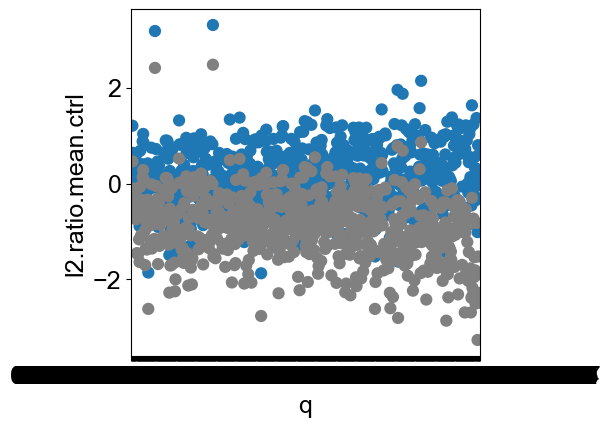

In [85]:
bst_dict = {} 
for CL in CLS:
    print(CL)
    fig, ax=plt.subplots(figsize=(4.5,4.5))
    x="delta.mean"
    data = short.loc[short["CL"]==CL].sort_values(by=x)
    data["q"] = data[x].rank(pct=True)
    d = data.loc[data.q>0.99].sort_values(by="l2.ratio.mean.ctrl")
    sns.pointplot(x="q", y="l2.ratio.mean.us", data=d, join=False)
    sns.pointplot(x="q", y="l2.ratio.mean.ctrl", data=d, join=False, color="grey")
#    ax.set_xticklabel("")
    break
    

## compare activity scores between two cell lines

In [87]:
table_bs = test_shuf.pivot(index='name', columns="CL", values="95ci.shuf.bootstrap")
table_bs = table_bs.reset_index()
table_bs = table_bs.rename(columns={"BJ": "BJ-bs", 'HEPG2':"HEPG2-bs"})

summary_table = pd.merge(table.reset_index(), table_bs)

# annotate
summary_table["effect"] = False
summary_table.loc[(summary_table["BJ-bs"]== "activating") &
                  (summary_table["HEPG2-bs"]== "activating"),
                 "effect"] = "activating"

summary_table.loc[(summary_table["BJ-bs"]== "silencing")&
                  (summary_table["HEPG2-bs"]== "silencing"),
                 "effect"] = "silencing"

summary_table.loc[(summary_table["BJ-bs"]== "activating")&
                  (summary_table["HEPG2-bs"].isin(["silencing", 'no effect'])),
                 "effect"] = "BJ-activating"
summary_table.loc[(summary_table["BJ-bs"]!= "activating")&
                  (summary_table["HEPG2-bs"]== "activating"),
                 "effect"] = "HEPG2-activating"

summary_table.head()

CL,name,type,BJ,HEPG2,BJ-bs,HEPG2-bs,effect
0,BJ_down-DEG-prom_ENSG00000258064_chr12:7167269...,DEG,-0.048854,-0.007771,no effect,no effect,False
1,BJ_down-DEG-prom_ENSG00000258064_chr12:7167293...,DEG,-0.109182,-0.044514,no effect,no effect,False
2,BJ_down-DEG-prom_ENSG00000258064_chr12:7167318...,DEG,0.068272,0.068092,no effect,no effect,False
3,BJ_down-DEG-prom_ENSG00000258064_chr12:7167342...,DEG,-0.042303,-0.088433,no effect,no effect,False
4,BJ_down-DEG-prom_ENSG00000258064_chr12:7167367...,DEG,0.068457,-0.145091,no effect,no effect,False


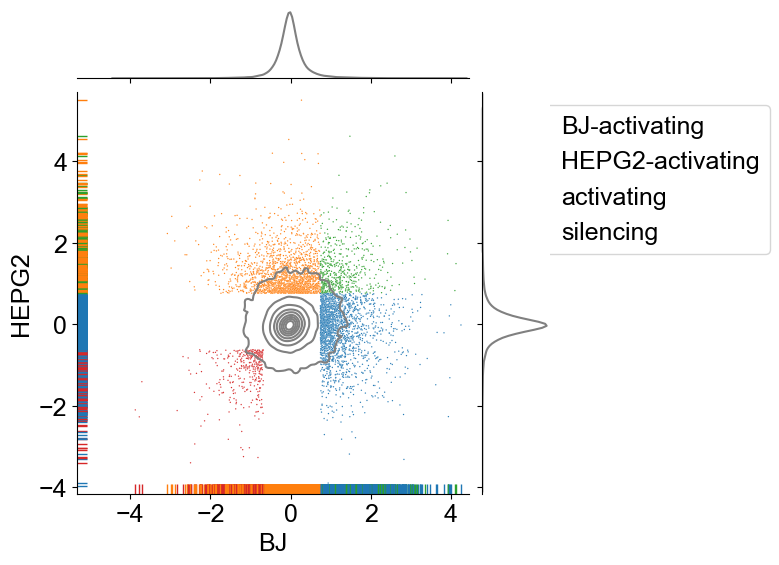

In [88]:
sns.jointplot(data=summary_table, 
              x="BJ", y="HEPG2", 
              #hue="effect", 
              kind="kde", color="grey"
             )

sns.scatterplot(data=summary_table.loc[summary_table["effect"]!=False], 
                x="BJ", y="HEPG2", hue="effect", s=1)
sns.rugplot(data=summary_table.loc[summary_table["effect"]!=False], 
                x="BJ", y="HEPG2", hue="effect")
plt.legend(bbox_to_anchor=(1,1))#.remove()

# mann whitney u

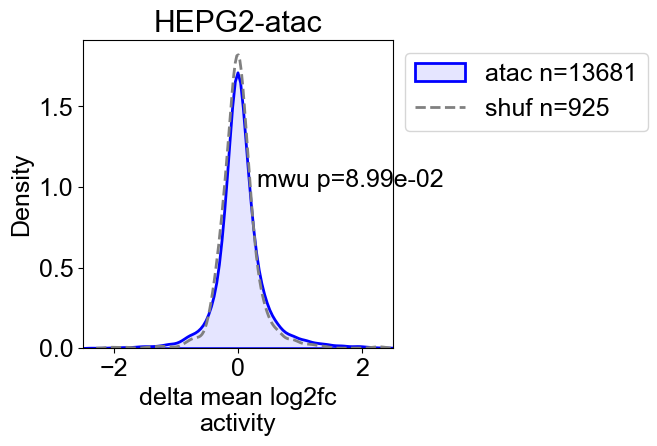

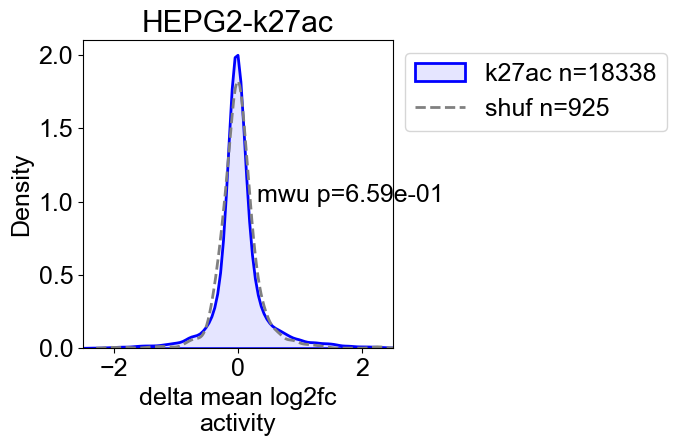

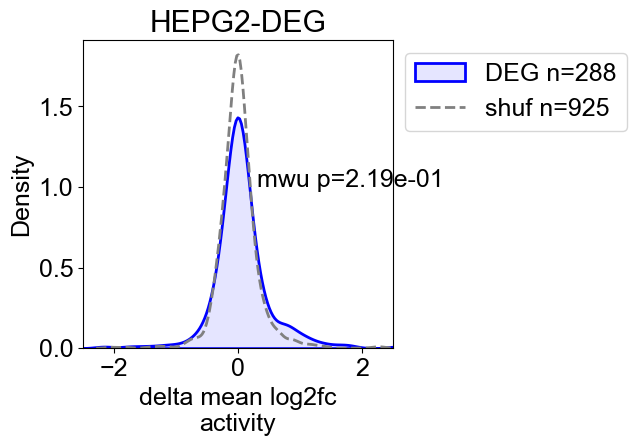

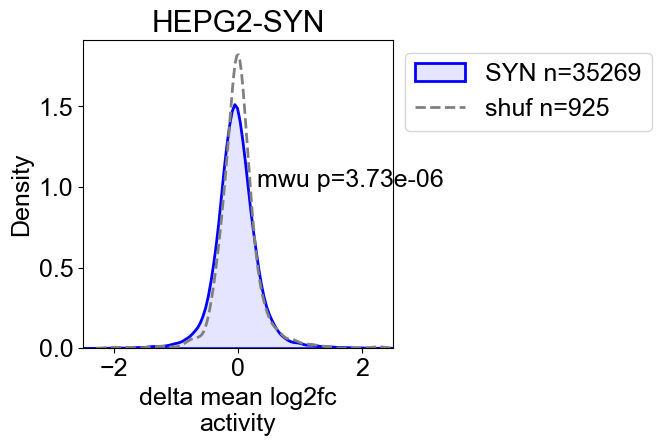

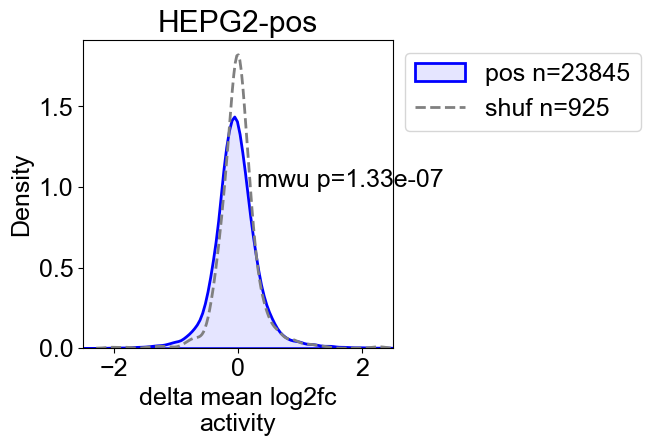

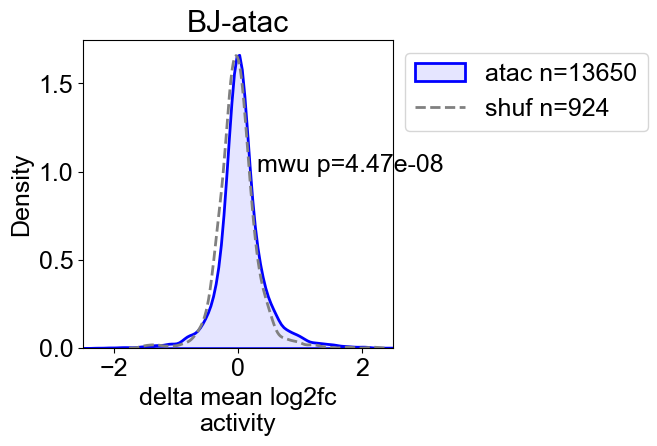

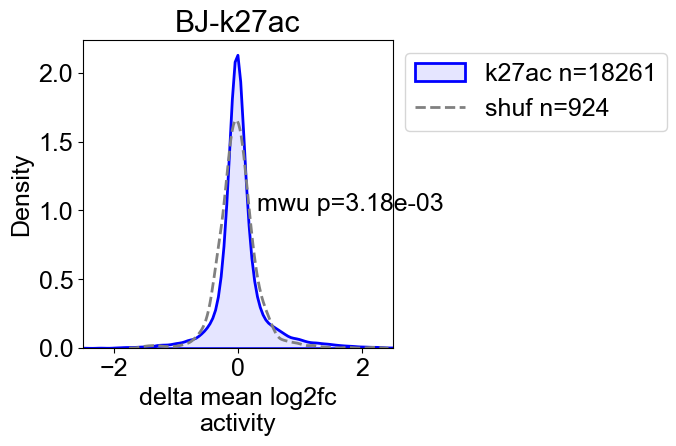

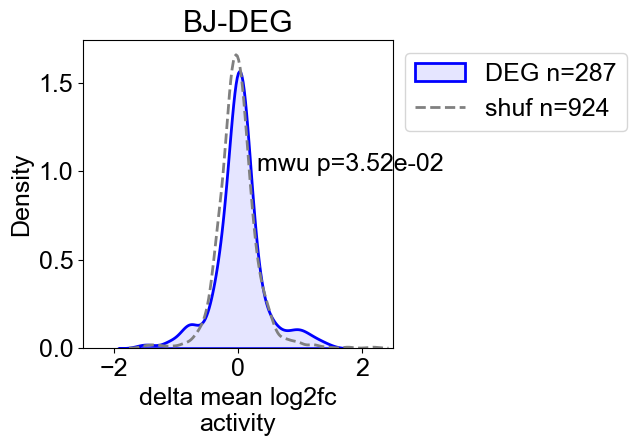

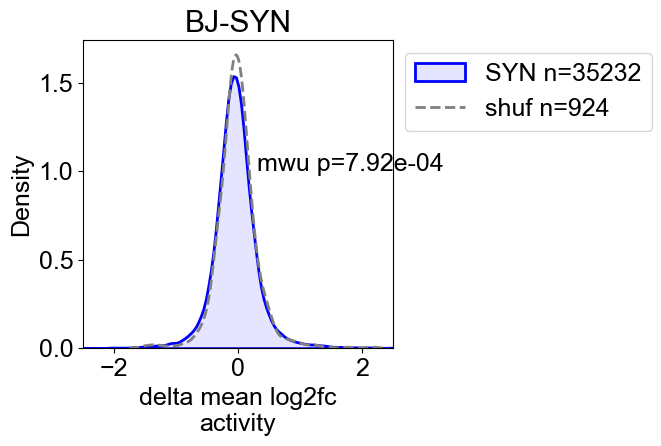

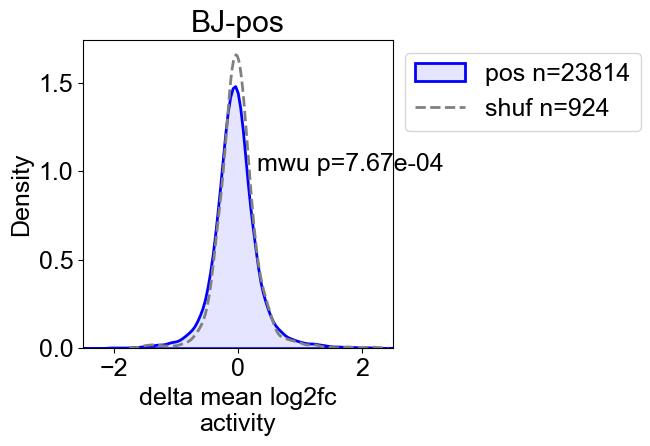

In [161]:
for CL in CLS:
    data = tiny.loc[tiny["CL"]==CL]
    for name in set(data["type"]):
        if name !='shuffle' and name !='neg':
            if name =="synthetic":
                name="SYN"

            shuf = data.loc[data["name"].str.contains('shuf'), "delta.mean"]
            test_group =data.loc[data["name"].str.contains(name), "delta.mean"]
            m, p = stats.mannwhitneyu(shuf, test_group) 

            fig, ax = plt.subplots(figsize=(4,4))


            sns.kdeplot(test_group, color='blue', 
                        fill=True, alpha=0.1, 
                        #alpha=0.3, 
                        lw=2,
                        label=(name + f" n={len(test_group)}")
                       )
            sns.kdeplot(shuf, color="grey", 
                        ls="--", 
                        #fill=True, 
                        #alpha=0.5, 
                         lw=2,
                        label=f"shuf n={len(shuf)}"
                       )

            ax.set(xlim=(-2.5, 2.5),
                  title=CL + "-" + name, 
                  xlabel = "delta mean log2fc\nactivity"
                  )
            ax.legend(bbox_to_anchor=(1,1))
            ax.text(0.3, 1, f"mwu p={p:0.2e}")

            out = os.path.join(RE, f"mwu.{CL}.{name}.v.shuf.pdf")
            plt.savefig(out, bbox_inches="tight")


In [151]:
tiny.head()

,delta.mean,CL,name,type
0,0.396674,HEPG2,SYNTHETIC:_Added_CCTTCCTG_GCCCGGGGG_TATACATA_a...,synthetic
2,0.104330,BJ,SYNTHETIC:_Added_CCTTCCTG_GCCCGGGGG_TATACATA_a...,synthetic
4,-0.231938,HEPG2,hob_k27ac_up_chr1:67427680-67427949,k27ac
6,-0.063360,BJ,hob_k27ac_up_chr1:67427680-67427949,k27ac
8,0.574042,HEPG2,SYNTHETIC:_The_motif_ATTAAA_was_added_in_Pos:8...,synthetic


# US v. ctrl

## mean / median correlations

In [ ]:
data = df
cols = ['l2.ratio.mean.ctrl', 'l2.ratio.mean.us',
        'l2.ratio.med.ctrl','l2.ratio.med.us', 
        'l2.ratio.std.ctrl','l2.ratio.std.us']

plotCorrHeatMap(data,cols)

In [ ]:
data[cols].describe()

## mean/ median scaled correlations

In [ ]:
list(t)

In [ ]:
# transformed data
data = t

plotCorrHeatMap(data,cols)

In [ ]:
data[cols].describe()

In [ ]:
ps = pd.merge(t[["name", 'pval']], df[["name", 'pval']], right_on = "name", left_on="name", suffixes = ("_transformed", "_not_transformed"))

In [ ]:
ps.head()

In [ ]:
ps_cols =["pval_not_transformed", "pval_transformed"]
sns.jointplot(x=ps_cols[0], y=ps_cols[1], data=ps, kind='hist')

In [ ]:
ps[ps_cols].corr(method="spearman")

## plots

### logFC distribution of datatypes

In [ ]:
col = "logFC"
sns.kdeplot(x=col, data=df, hue= "type", common_norm=False,
            multiple="stack"
           )

In [ ]:
set(df.type)

In [ ]:
labels=["atac", "pos", "k27ac", "DEG", "neg"]
simpledf = df.loc[df["type"].isin(labels)]

In [ ]:
col = "logFC"
data=simpledf
fig, ax= plt.subplots(figsize=(6,6))
sns.ecdfplot(x=col, data=data, hue= "type", 
             #common_norm=False, 
             #multiple="stack",
            #stat="percent"
           )
ax.set(xlim=(-1,1), 
      xlabel="l2fc")

In [ ]:
# add type information back into transformed dataframe
t = pd.merge(t, df[["name", "type"]])

In [ ]:
cols = ["l2.ratio.med.us", "l2.ratio.med.ctrl"]
datas = [df, t]
for data in datas:
    for col in cols:
        fig, ax = plt.subplots()
        sns.kdeplot(x=col, data=data, label = col, hue="type", common_norm=False)

# correlation between ctrl x US
- raw values. Need to be centered per ctrl/US condition?

In [ ]:
data_dict = {"raw":(df, [-4,5]),
            'standardized': (t, [-6,9])}

## median

In [ ]:
def jointPlot(x, y, data, id_):
    
    # pick color
    if "med" in x:
        color = "b"
    elif "mean" in x:
        color = "g"
    else:
        color="orange"
        
        
    sns.jointplot(x=x,
                  y=y,
                  data=data.loc[data["pval"]<0.05], 
                  color=color,
                  marginal_ticks=True, 
                  alpha=0.2
             )

    # don't plot identity line when looking at fc
    #if "delta" not in y:
     #   plt.plot(id_,id_, c="k", ls="--")
    
    # axes
    plt.axhline(0, c="grey", ls="--")
    plt.axvline(0, c="grey", ls="--")

In [ ]:
# change datatype
df["pval"] = df["pval"].astype(float)
t["pval"] = t["pval"].astype(float)

df["-log10p"] = np.log10(df["pval"])*-1
t["-log10p"] = np.log10(t["pval"])*-1

In [ ]:
x="l2.ratio.med.ctrl"
y="l2.ratio.med.us"

data, id_ = data_dict["standardized"]

jointPlot(x, y, data, id_)

### activity x fold change

In [ ]:
x= "delta.med"
y= "-log10p"

data, id_ = data_dict["raw"]

id_ = [1,3]
jointPlot(x, y, data, id_)

In [ ]:
x= "delta.med"
y= "-log10p"

data, id_ = data_dict["raw"]

id_ = [1,3]
jointPlot(x, y, data, id_)

In [ ]:
data["mean.var.us"] = data["l2.ratio.mean.us"]/data["l2.ratio.std.us"]

In [ ]:
data["mean.var.us"].describe()

In [ ]:
sns.histplot(data["l2.ratio.std.us"])
sns.histplot(data["l2.ratio.std.ctrl"],color="grey", ls="--")
ax.plot()

In [ ]:
x="delta.med"
y= "-log10p"
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

In [ ]:
x= "l2.ratio.mean.ctrl"
y="l2.ratio.mean.us"

data, id_ = data_dict["raw"]

jointPlot(x, y, data, id_)

In [ ]:
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

In [ ]:
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

In [ ]:
x= "l2.ratio.std.ctrl"
y="l2.ratio.std.us"
data, id_ = data_dict["standardized"]
jointPlot(x, y, data, id_)

In [ ]:
data, id_ = data_dict["standardized"] 
sns.jointplot(y="l2.ratio.mean.us", data=data.loc[data["response"]==True], x= "l2.ratio.mean.ctrl", 
                marginal_ticks=True, 
                hue_order = [True, False],
               hue='response')


#plt.plot(id_,id_, c="k", ls="--")
plt.axhline(0, c="b", ls="--")
plt.axvline(0, c="b", ls="--")

# p-value distribution 

In [ ]:
df["pval"] = df["pval"].astype(float)

In [ ]:
df["pval"].describe()

In [ ]:
sns.histplot(np.log10(df["pval"])*-1)

In [ ]:
len(df.loc[df["pval"]<0.05])

In [ ]:
import pylab

In [ ]:
np.array(df["pval"])

In [ ]:
stats.probplot(np.array(df["pval"]), dist="norm", plot=pylab)
#pylab.show()

In [ ]:
stats.probplot(np.array(t["pval"]), dist="norm", plot=pylab)
#pylab.show()

In [ ]:
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()